# Titanic (advanced)
The Titanic problem is a nice playground to apply advanced ML methods. In this notebook, I used Scikit Learn ColumnTransformer and Pipeline classes to implement 6 different estimators and I combined them with the VotingClassifier to get my final estimator.  

Final score is 0.80861, in the top 10% of all participants.

In [2]:
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, Binarizer

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import BernoulliNB

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = 8, 12
import seaborn as sns
sns.set_style("darkgrid")

# Exploratory Data Analysis
Since this is a well known dataset, I will keep EDA short. 

## Description of the dataset
The code below gives a brief description of the training data set:
* number of observations and of features
* an extract of several random observations from the dataset to get a closer look at the features available
* the count of null values and distinct values for each feature

In [3]:
# Load training set
dataset = pd.read_csv('./input/train.csv', index_col = 'PassengerId')
target = 'Survived'
features = [c for c in list(dataset.columns.values) if c != target]

# size of the dataset
print('Dataset = {:d} observations x {:d} features (including target)'.format(dataset.shape[0], dataset.shape[1]))
# list of features
dataset.sample(5)

Dataset = 891 observations x 11 features (including target)


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
625,0,3,"Bowen, Mr. David John ""Dai""",male,21.0,0,0,54636,16.1000,NaN,S
325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.5500,NaN,S
376,1,1,"Meyer, Mrs. Edgar Joseph (Leila Saks)",female,NaN,1,0,PC 17604,82.1708,NaN,C
305,0,3,"Williams, Mr. Howard Hugh ""Harry""",male,NaN,0,0,A/5 2466,8.0500,NaN,S
642,1,1,"Sagesser, Mlle. Emma",female,24.0,0,0,PC 17477,69.3000,B35,C


In [4]:
summary = pd.DataFrame(np.array([dataset.dtypes, 
                                 dataset.isnull().sum(), 
                                 dataset.nunique()]),
                       index=['Dtype', 'NbrNullValues', 'NbrDistinctVal'],                       
                       columns=np.array(list(dataset)))
display(summary)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
Dtype,int64,int64,object,object,float64,int64,int64,object,float64,object,object
NbrNullValues,0,0,0,0,177,0,0,0,0,687,2
NbrDistinctVal,2,3,891,2,88,7,7,681,248,147,3


## Interaction with the target
A plot of survival probability versus *Sex* and *Pclass* shows the importance of this 2 features. It shows also that the relation between *Pclass* and *Survived* is not linear and depends also on the feature *Sex*.  

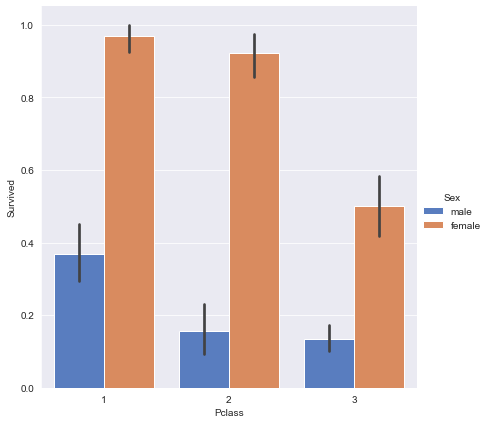

In [5]:
sns.catplot(x='Pclass', y=target, hue='Sex', data=dataset, height=6, kind='bar', palette='muted');

A plot of of *Age* for the 2 categories *Sex* and *Survived* shows a high proportion of survival for young men (roughly under 12 years). We will use this information for Bernouilli Naive Bayes classiifer, to binarize the age variable at an adequate threshold.  

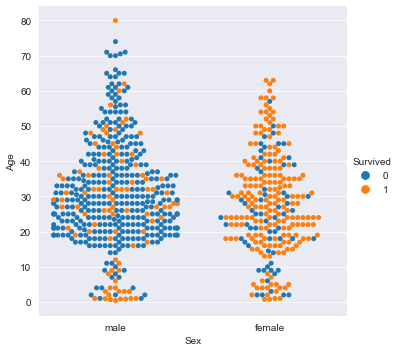

In [7]:
sns.catplot(x='Sex', y='Age', hue='Survived', data=dataset, kind='swarm');

## Features Engineering
The feature engineering step is simple and consists in:
* calculating the total family size as the sum of siblings/spouses (*SibSp*) and parents/children (*Parch*) plus 1
* extracting the family name and the title (and grouping less frequent values of this feature)

In [8]:
def prepare_data(data):
    df = data.copy()
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['FamilyName'] = df['Name'].apply(lambda x: x.split(',')[0])
    # remove left/right space characters, and replace other space characters with an underscore 
    df['FamilyName'] = df['FamilyName'].apply(lambda x: x.strip().replace(' ', '_'))
    
    df['Title'] = df['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())  
    # group similar values 
    df['Title'].replace(['Mr','Don','Rev','Dr','Major','Sir','Col','Capt','Jonkheer'], 'Mr', inplace=True) 
    df['Title'].replace(['Mrs','Mme','Lady','the Countess','Dona'], 'Mrs', inplace=True)     
    df['Title'].replace(['Miss','Ms','Mlle'], 'Miss', inplace=True)
    # passenger 797 Dr. Leader is a female and is misclassified. Should be corrected
    df.loc[(df.Sex == 'female') & (df.Title == 'Mr'), 'Title'] = 'Mrs'
    return df
    
data_prepared = prepare_data(dataset)  
data_prepared.sample(3)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,FamilyName,Title
PassengerId,,,,,,,,,,,,,,
387,0,3,"Goodwin, Master. Sidney Leonard",male,1.0,5,2,CA 2144,46.90,NaN,S,8,Goodwin,Master
235,0,2,"Leyson, Mr. Robert William Norman",male,24.0,0,0,C.A. 29566,10.50,NaN,S,1,Leyson,Mr
404,0,3,"Hakkarainen, Mr. Pekka Pietari",male,28.0,1,0,STON/O2. 3101279,15.85,NaN,S,2,Hakkarainen,Mr


# Models
I implemented the following 6 models:
* 2 logistic regressions (one without using family names, and the second with family names)
* 1 k-Nearest Neighbors
* 1 decision tree
* 1 random forest classifier
* 1 Naives Bayes with binary features  
3 models include the feature FamilyName (the second Logistic Regression, the Decision tree and the Naive Bayes model). The 3 other models do not use this feature. 

All models are implemented following the same pattern:
* use a new train/test split (in order to increase the variablity between the models)
* define a ColumnTransformer to handle differently the preprocessing of features used
* define a pipeline including the ColumnTransformer, eventually other preprocessing transformers, and the predictive model
* optimize the hyperparameters of the pipeline using a grid search (with 5-fold cross validation)
* calculate the score of the best estimator on the test data

Finally, the best estimators for the 6 models are grouped together, using soft voting (ie ensembling the predicted probabilities of the 6 models) with weights set to the score of each model on the test dataset. 

In [9]:
features = [col for col in list(data_prepared) if col != target]
X = data_prepared[features]
y = data_prepared[[target]]

## Logistic regression
We start with a simple Logistic Regression model, using only the 6 features *Sex*, *Pclass*, *Title*, *Age*, *Fare* and *FamilySize*.  

In [10]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.4, stratify=y)

ct_lr1 = ColumnTransformer( transformers = 
                       [('tr_sex', OrdinalEncoder(), ['Sex']),
                        ('tr_class', OneHotEncoder(categories='auto', drop='first'), ['Pclass','Title']),                      
                        ('tr_age', SimpleImputer(), ['Age', 'Fare']), 
                        ('tr_keep', 'passthrough', ['FamilySize']),
                        ('tr_embarked', Pipeline([
                            ('inputer', SimpleImputer(strategy='most_frequent')),
                            ('onehot', OneHotEncoder(categories='auto', drop='first'))]), ['Embarked']),
                       ],                       
                      remainder='drop', sparse_threshold=0)

model_lr1 = Pipeline([
    ('col', ct_lr1),
    ('scaler', StandardScaler()),    
    ('reg', LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)),
    ])

param_lr1 = {
    'reg__penalty': ['l1', 'l2'],
    'reg__C': 2.0**np.arange(-5, +3) # [0.01, 0.1, 1.0, 10., 100.],
    }

grid_lr1 = GridSearchCV(model_lr1, param_lr1, cv=5, iid=False, verbose=1)
grid_lr1.fit(X_train, y_train['Survived']);

print('Logistic regression - best parameters: {}'.format(grid_lr1.best_params_))
print('Logistic regression - score on training data = {:.4f}'.format(grid_lr1.best_score_))
lr1_test_score = grid_lr1.score(X_valid, y_valid)
print('Logistic regression - score on validation data = {:.4f}'.format(lr1_test_score))

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Logistic regression - best parameters: {'reg__C': 0.125, 'reg__penalty': 'l1'}
Logistic regression - score on training data = 0.8183
Logistic regression - score on validation data = 0.8459


[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    6.3s finished


### Linear regression with feature FamilyName
I use only l1 regularization for this regression due to the high number of categorical variables.

In [11]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.4, stratify=y)

ct_lr2 = ColumnTransformer( transformers = 
                       [('tr_sex', OrdinalEncoder(), ['Sex']),
                        ('tr_class', OneHotEncoder(categories='auto', drop='first'), ['Pclass','Title']),                      
                        ('tr_age', SimpleImputer(), ['Age', 'Fare']),
                        ('tr_keep', 'passthrough', ['FamilySize']),   
                        ('tr_embarked', Pipeline([
                            ('inputer', SimpleImputer(strategy='most_frequent')),
                            ('onehot', OneHotEncoder(categories='auto', drop='first'))]), ['Embarked']),                        
                        ('tr_name', OneHotEncoder(categories='auto', drop=None, handle_unknown='ignore'), ['FamilyName']),                              
                       ],                       
                      remainder='drop', sparse_threshold=0)

model_lr2 = Pipeline([
    ('col', ct_lr2),
    ('scaler', StandardScaler()),    
    ('reg', LogisticRegression(penalty='l1', solver='liblinear', max_iter=500)),
    ])

param_lr2 = {
    'reg__C': 2.0**np.arange(-5, +3), #[0.1, 0.4, 1.0, 2.5],
    }

grid_lr2 = GridSearchCV(model_lr2, param_lr2, cv=5, iid=False, verbose=1)
grid_lr2.fit(X_train, y_train['Survived']);

print('Logistic regression - best parameters: {}'.format(grid_lr2.best_params_))
print('Logistic regression - score on training data = {:.4f}'.format(grid_lr2.best_score_))
lr2_test_score = grid_lr2.score(X_valid, y_valid)
print('Logistic regression - score on validation data = {:.4f}'.format(lr2_test_score))

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    7.7s finished


Logistic regression - best parameters: {'reg__C': 0.125}
Logistic regression - score on training data = 0.8297
Logistic regression - score on validation data = 0.8459


## K-Nearest Neighbors

In [12]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.4, stratify=y)

ct_knn1 = ColumnTransformer( transformers = 
                       [('tr_sex', OrdinalEncoder(), ['Sex']),
                        ('tr_class', OneHotEncoder(categories='auto', drop=None), ['Pclass','Title']),                      
                        ('tr_age', SimpleImputer(), ['Age', 'Fare']),  
                        ('tr_embarked', Pipeline([
                            ('inputer', SimpleImputer(strategy='most_frequent')),
                            ('onehot', OneHotEncoder(categories='auto', drop='first'))]), ['Embarked']),                        
                        ('tr_keep', 'passthrough', ['FamilySize'])                          
                       ],                       
                      remainder='drop', sparse_threshold=0)

model_knn1 = Pipeline([
    ('col', ct_knn1),    
    ('scaler', StandardScaler()),    
    ('knn', KNeighborsClassifier(n_neighbors=3)),
    ])

param_knn1 = {
    'knn__n_neighbors': [3, 5, 7, 9, 11, 13],
    'knn__weights': ['uniform', 'distance'],
    }

grid_knn1 = GridSearchCV(model_knn1, param_knn1, cv=5, iid=False, verbose=1)
grid_knn1.fit(X_train, y_train['Survived']);

print('KNN - best parameters: {}'.format(grid_knn1.best_params_))
print('KNN - score on training data = {:.4f}'.format(grid_knn1.best_score_))
knn1_test_score = grid_knn1.score(X_valid, y_valid)
print('KNN - score on validation data = {:.4f}'.format(knn1_test_score))

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


KNN - best parameters: {'knn__n_neighbors': 7, 'knn__weights': 'uniform'}
KNN - score on training data = 0.8333
KNN - score on validation data = 0.8039


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    5.0s finished


## Decision Tree

In [13]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.4, stratify=y)

ct_dt1 = ColumnTransformer( transformers = 
                       [('tr_sex', OrdinalEncoder(), ['Sex']),
                        ('tr_class', OneHotEncoder(categories='auto', drop=None), ['Pclass','Title']),                      
                        ('tr_age', SimpleImputer(), ['Age', 'Fare']), 
                        ('tr_embarked', Pipeline([
                            ('inputer', SimpleImputer(strategy='most_frequent')),
                            ('onehot', OneHotEncoder(categories='auto', drop='first'))]), ['Embarked']),   
                        ('tr_name', OneHotEncoder(categories='auto', drop=None, handle_unknown='ignore'), ['FamilyName']),                          
                        ('tr_keep', 'passthrough', ['FamilySize'])                          
                       ],                       
                      remainder='drop', sparse_threshold=0)

model_dt1 = Pipeline([
#    ('name_tr', FamilyNameTransformer(minimum_count=6)),    
    ('col', ct_dt1),    
#    ('scaler', StandardScaler()),    
    ('tree', DecisionTreeClassifier()),
    ])

param_dt1 = {
#    'name_tr__minimum_count': [4,5,7], #[4,5,6,7],    
    'tree__max_depth': [4, 5, 6, 7, 8],
    'tree__min_samples_leaf': [1,2,3],
    }

grid_dt1 = GridSearchCV(model_dt1, param_dt1, cv=5, iid=False, verbose=1)
grid_dt1.fit(X_train, y_train['Survived']);

print('Decision Tree - best parameters: {}'.format(grid_dt1.best_params_))
print('Decision Tree - score on training data = {:.4f}'.format(grid_dt1.best_score_))
dt1_test_score = grid_dt1.score(X_valid, y_valid)
print('Decision Tree - score on validation data = {:.4f}'.format(dt1_test_score))

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Decision Tree - best parameters: {'tree__max_depth': 7, 'tree__min_samples_leaf': 3}
Decision Tree - score on training data = 0.8428
Decision Tree - score on validation data = 0.7983


[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:    7.5s finished


## RandomForest classifier

In [14]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.4, stratify=y)

ct_rfc1 = ColumnTransformer( transformers = 
                       [('tr_sex', OrdinalEncoder(), ['Sex']),
                        ('tr_class', OneHotEncoder(categories='auto', drop=None), ['Pclass','Title']),                      
                        ('tr_age', SimpleImputer(), ['Age', 'Fare']), 
                        ('tr_embarked', Pipeline([
                            ('inputer', SimpleImputer(strategy='most_frequent')),
                            ('onehot', OneHotEncoder(categories='auto', drop='first'))]), ['Embarked']),                           
                        ('tr_keep', 'passthrough', ['FamilySize'])                          
                       ],                       
                      remainder='drop', sparse_threshold=0)

model_rfc1 = Pipeline([
    ('col', ct_rfc1),    
#    ('scaler', StandardScaler()),    
    ('rfc', RandomForestClassifier()),
    ])

param_rfc1 = {
    'rfc__n_estimators': [10, 15, 20],
    'rfc__max_features': [4, 5, 6, 7],
    'rfc__min_samples_leaf': [5, 6, 7, 8],
    }

grid_rfc1 = GridSearchCV(model_rfc1, param_rfc1, cv=5, iid=False, verbose=1)
grid_rfc1.fit(X_train, y_train['Survived']);

print('Random Forest - best parameters: {}'.format(grid_rfc1.best_params_))
print('Random Forest - score on training data = {:.4f}'.format(grid_rfc1.best_score_))
rfc1_test_score = grid_rfc1.score(X_valid, y_valid)
print('Random Forest - score on validation data = {:.4f}'.format(rfc1_test_score))

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Random Forest - best parameters: {'rfc__max_features': 5, 'rfc__min_samples_leaf': 8, 'rfc__n_estimators': 10}
Random Forest - score on training data = 0.8483
Random Forest - score on validation data = 0.8151


[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:   28.4s finished


## Naive Bayes binomial
We binarize the variable *Age* and include this threshold in the parameter grid to optimize hyperparameters. Based on the information obtained in the EDA phase, we search the optimal value of the threshold in the 6 to 10 years range.

In [15]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.4, stratify=y)

ct_nb1 = ColumnTransformer( transformers = 
                       [('tr_sex', OrdinalEncoder(), ['Sex']),
                        ('tr_class', OneHotEncoder(categories='auto', drop=None), ['Pclass','Title']),                      
                        ('tr_age', Pipeline([
                            ('inputer', SimpleImputer()), 
                            ('bin', Binarizer(threshold=12))]), ['Age']), 
                        ('tr_embarked', Pipeline([
                            ('inputer', SimpleImputer(strategy='most_frequent')),
                            ('onehot', OneHotEncoder(categories='auto', drop='first'))]), ['Embarked']),  
                        ('tr_name', OneHotEncoder(categories='auto', drop=None, handle_unknown='ignore'), ['FamilyName']),                          
                       ],                       
                      remainder='drop', sparse_threshold=0)

model_nb1 = Pipeline([
    ('col', ct_nb1),    
#    ('scaler', StandardScaler()),    
    ('nb', BernoulliNB()),
    ])

param_nb1 = {
    'col__tr_age__bin__threshold': [6, 7, 8, 9, 10],
    'nb__alpha': 2.0**np.arange(-8, +1),
    }

grid_nb1 = GridSearchCV(model_nb1, param_nb1, cv=5, iid=False, verbose=1)
grid_nb1.fit(X_train, y_train['Survived']);

print('Naive Bayes - best parameters: {}'.format(grid_nb1.best_params_))
print('Naive Bayes - score on training data = {:.4f}'.format(grid_nb1.best_score_))
nb1_test_score = grid_nb1.score(X_valid, y_valid)
print('Naive Bayes - score on validation data = {:.4f}'.format(nb1_test_score))

Fitting 5 folds for each of 45 candidates, totalling 225 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Naive Bayes - best parameters: {'col__tr_age__bin__threshold': 10, 'nb__alpha': 0.015625}
Naive Bayes - score on training data = 0.8147
Naive Bayes - score on validation data = 0.7871


[Parallel(n_jobs=1)]: Done 225 out of 225 | elapsed:   23.3s finished


### Ensemble 

In [16]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.4, stratify=y)

estimators = [
     ('lg1', grid_lr1.best_estimator_),
     ('lg2', grid_lr2.best_estimator_),    
     ('knn', grid_knn1.best_estimator_),
     ('dtc', grid_dt1.best_estimator_),    
     ('rfc', grid_rfc1.best_estimator_),   
     ('nb', grid_nb1.best_estimator_),     
     ]
weights = [lr1_test_score, lr2_test_score,  knn1_test_score, dt1_test_score, rfc1_test_score, nb1_test_score]

clf = VotingClassifier(estimators=estimators, voting='soft', weights=weights)
clf.fit(X_train, y_train['Survived'])
print(clf.score(X_valid, y_valid))

0.8319327731092437


# Submission
We retrain the ensemble estimator on the full training dataset, before predicting labels of the submission dataset.  

In [17]:
# read and preprocess test data
X_submission = pd.read_csv('./input/test.csv', index_col = 'PassengerId')
X_submission = prepare_data(X_submission)  

# fit on full training set
clf.fit(X, y['Survived'])
y_pred = clf.predict(X_submission)
X_submission['Survived'] = y_pred

X_submission.to_csv('./output/result.csv', 
                columns=['Survived'],
                header=True,
                index=True)
